In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy.external as sce
%matplotlib inline

mitos = sc.queries.mitochondrial_genes(host="www.ensembl.org", org="sscrofa")
biots = sc.queries.biomart_annotations(host='www.ensembl.org', org='sscrofa',
                                       attrs=['ensembl_gene_id','gene_biotype',
                                              'external_gene_name'])
biots.dropna(subset=['ensembl_gene_id'], inplace=True)
biots = biots.set_index('ensembl_gene_id')

ModuleNotFoundError: No module named 'scanpy'

In [3]:
path = '../../../data/egenesis-data-processed/research/' +\
        'Sus_scrofa/yorkshire/wt/P48.9/PBMC/' +\
        'scrna_seq/illumina_hiseq_truseq_10xv3/test3/' +\
        'kallisto/bustools_counts/' +\
        'L457_1_S1_L001_R_bus_output_genecount/'
genes = sc.read_mtx(path + 'gene.mtx')
genes.var_names = pd.read_csv(path + 'gene.genes.txt', header=None)[0]
genes.obs_names = pd.read_csv(path + 'gene.barcodes.txt', header=None)[0]
print(genes.X.sum())
sc.pp.filter_genes(genes, min_cells=5)
sc.pp.filter_cells(genes, min_genes=200)

NameError: name 'sc' is not defined

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'gene_biotype' as categorical
... storing 'external_gene_name' as categorical


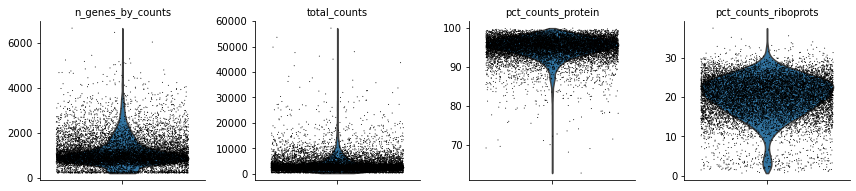

In [81]:
genes.var = genes.var.join(biots)
genes.var['protein'] = genes.var.gene_biotype.str.contains('protein').values
genes.var['riboprots'] = genes.var.external_gene_name.fillna('').astype(str).str.contains('RPL\d|RPS\d+$')
sc.pp.calculate_qc_metrics(genes, qc_vars=['protein'],
                           percent_top=None, log1p=False,
                           inplace=True)
sc.pp.calculate_qc_metrics(genes, qc_vars=['riboprots'],
                           percent_top=None, log1p=False,
                           inplace=True)
sc.pl.violin(genes, ['n_genes_by_counts', 'total_counts', 'pct_counts_protein', 'pct_counts_riboprots'],
             jitter=0.4, multi_panel=True)

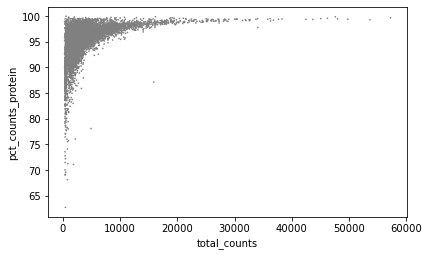

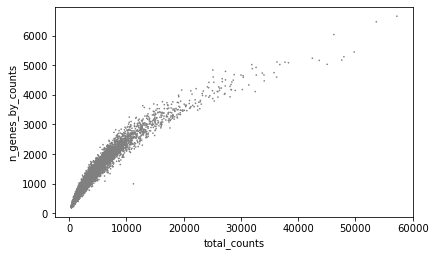

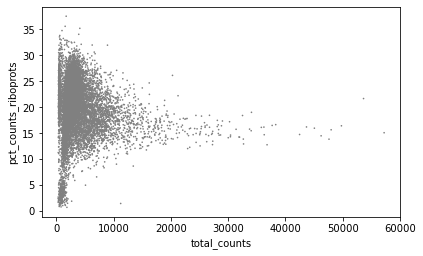

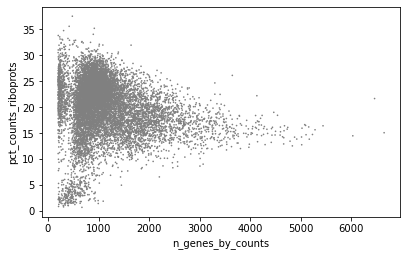

In [82]:
sc.pl.scatter(genes, x='total_counts', y='pct_counts_protein')
sc.pl.scatter(genes, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(genes, x='total_counts', y='pct_counts_riboprots')
sc.pl.scatter(genes, x='n_genes_by_counts', y='pct_counts_riboprots')

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


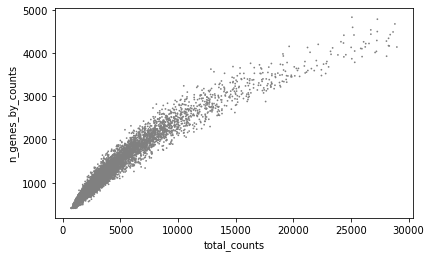

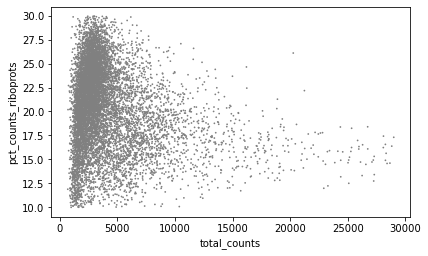

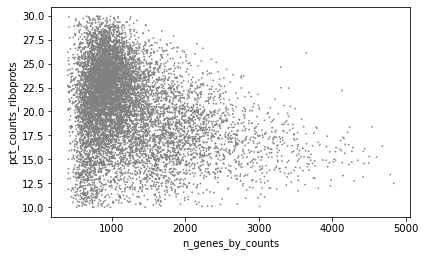

In [83]:
genes = genes[(genes.obs.n_genes_by_counts > 400) &
              (genes.obs.total_counts.between(10 ** 2, 3 * 10 ** 4)) &
              (genes.obs.pct_counts_protein > 90) &
              (genes.obs.pct_counts_riboprots.between(10, 30)), :]
sc.pl.scatter(genes, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(genes, x='total_counts', y='pct_counts_riboprots')
sc.pl.scatter(genes, x='n_genes_by_counts', y='pct_counts_riboprots')

In [84]:
sc.pp.normalize_per_cell(genes, counts_per_cell_after=1e4)
run = False

genes

Trying to set attribute `.obs` of view, copying.
/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 9833 × 12513
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_protein', 'pct_counts_protein', 'total_counts_riboprots', 'pct_counts_riboprots', 'n_counts'
    var: 'n_cells', 'gene_biotype', 'external_gene_name', 'protein', 'riboprots', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

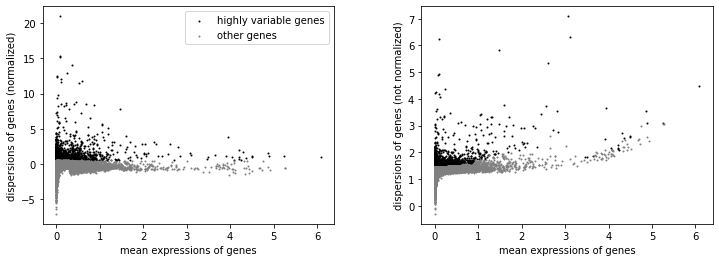

In [85]:
if run is False:
    sc.pp.log1p(genes)
run = True

genes.raw = genes

sc.pp.highly_variable_genes(genes, n_top_genes=2000)
sc.pl.highly_variable_genes(genes)

In [86]:
genes = genes[:, genes.var.highly_variable]
sc.pp.regress_out(genes, ['total_counts'])
sc.pp.scale(genes, max_value=10)

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


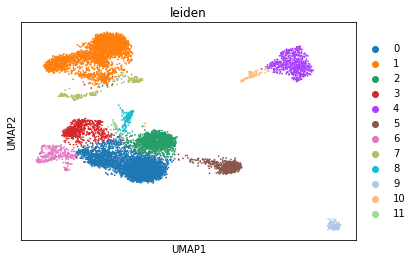

In [88]:
sc.tl.pca(genes, n_comps=80)
sc.pp.neighbors(genes, n_neighbors=20, n_pcs=80)
sc.tl.umap(genes)
sc.tl.leiden(genes, resolution=0.4)
sc.pl.umap(genes, color=['leiden'])

In [ ]:
sc.tl.rank_genes_groups(genes, 'leiden', method='t-test')
markers = pd.DataFrame(genes.uns['rank_genes_groups']['names'])
sc.pl.rank_genes_groups(genes, gene_symbols='external_gene_name')

In [59]:
def subcluster(cluster, n_neighbors=20, resolution=0.2):
    tmp = genes[genes.obs['leiden'] == cluster,:]
    ad_sub = sc.AnnData(tmp.raw.X, obs=tmp.obs, var=tmp.raw.var)
    sc.pp.highly_variable_genes(ad_sub, n_top_genes=2000)
    sc.pl.highly_variable_genes(ad_sub)
    ad_sub = ad_sub[:, ad_sub.var.highly_variable]
    sc.pp.regress_out(ad_sub, ['total_counts'])
    sc.pp.scale(ad_sub, max_value=10)
    sc.tl.pca(ad_sub, n_comps=80)
    sc.pp.neighbors(ad_sub, n_neighbors=n_neighbors, n_pcs=80)
    sc.tl.umap(ad_sub)
    sc.tl.leiden(ad_sub, resolution=resolution)
    sc.pl.umap(ad_sub, color=['leiden'])
    sc.tl.rank_genes_groups(ad_sub, 'leiden', method='t-test')
    sc.pl.rank_genes_groups(ad_sub, gene_symbols='external_gene_name')
    return ad_sub

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


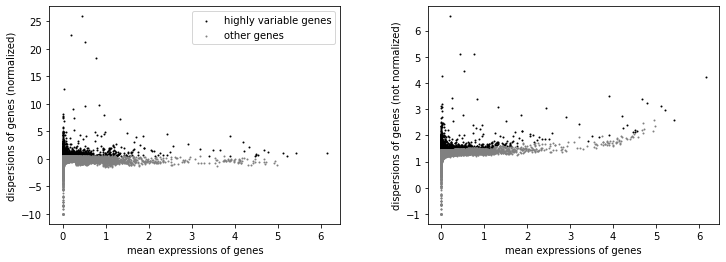

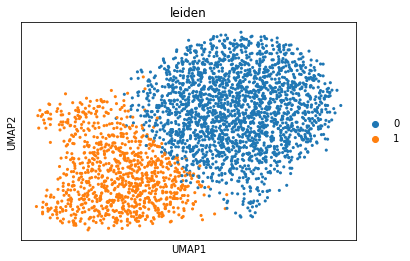

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


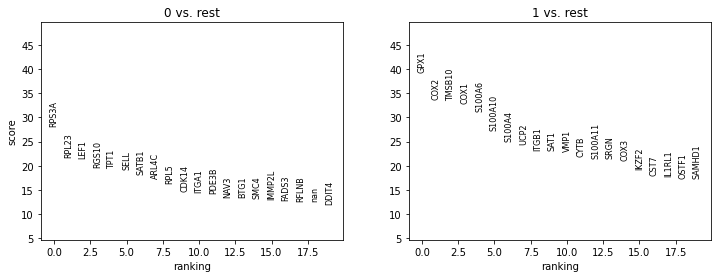

In [60]:
sub0 = subcluster('0', n_neighbors=50, resolution=0.4)

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


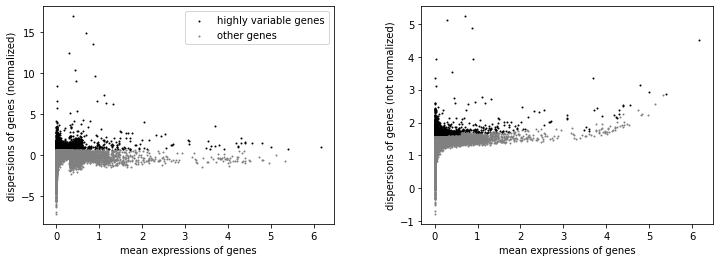

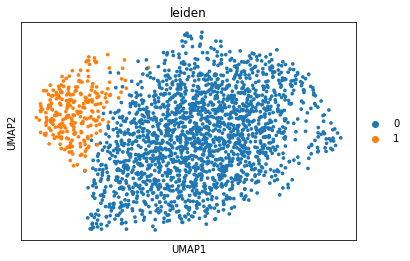

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


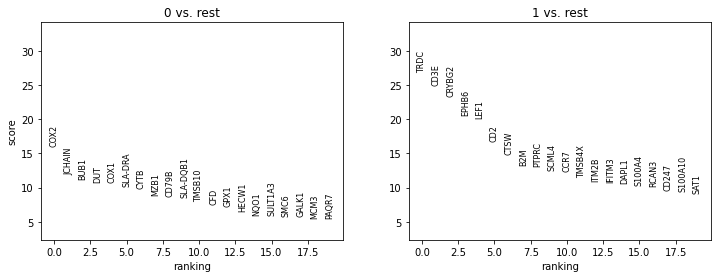

In [61]:
sub1 = subcluster('1', n_neighbors=50, resolution=0.4)

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


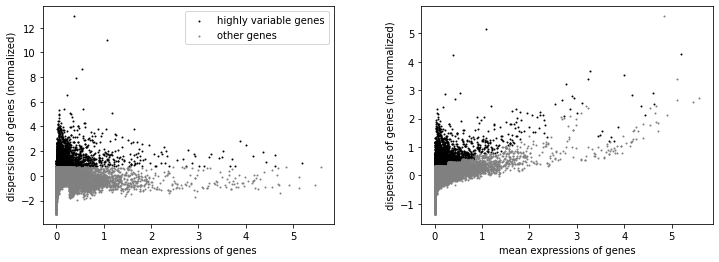

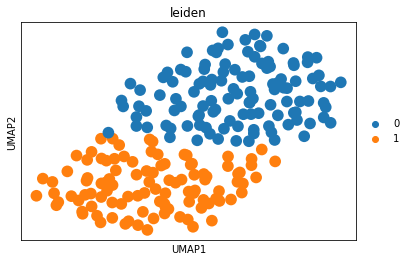

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


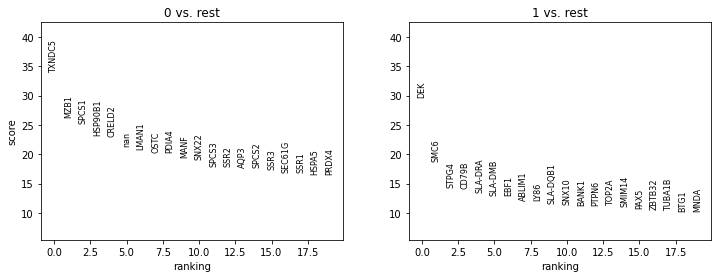

In [62]:
sub1 = subcluster('8', n_neighbors=50, resolution=0.4)

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


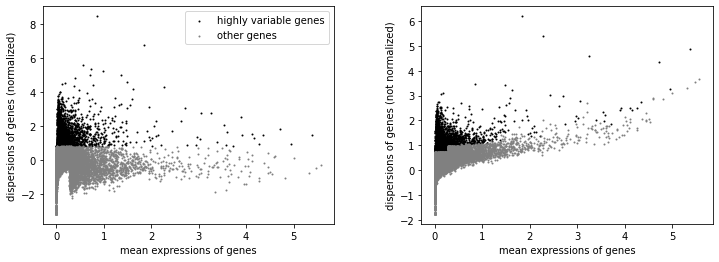

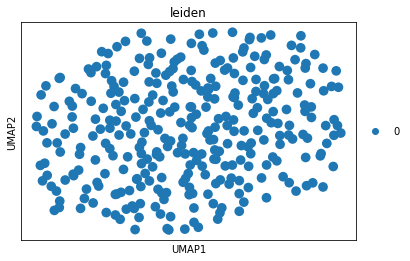

/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: Mean of empty slice.
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
/home/ec2-user/data/miniconda3/envs/scanpy/lib/python3.6/site-packages/scanpy/plotting/_tools/__init__.py:322: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(ymin, ymax)


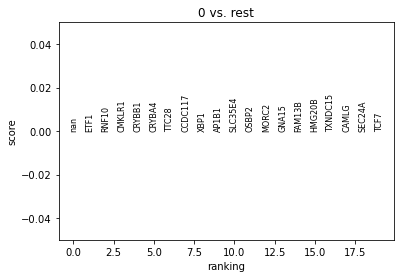

In [63]:
sub1 = subcluster('7', n_neighbors=50, resolution=0.4)